# Application

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import json

import re
from scipy.stats import entropy


Load data

In [2]:
filepath = "/Users/david/Desktop/Research/Project/Data/Application/clean_datasets"

df_all = pd.read_csv(os.path.join(filepath, "clustered_labels.csv"))

Standardize character names

In [3]:
with open(os.path.join(filepath, "character_name_equivalencies.json"), 'r') as f:
    character_name_equivalencies = json.load(f)

# Change dictionary formats
standard_character_name_lookup = {}
for name, other_names_list in character_name_equivalencies.items():
    for other_name in other_names_list:
        standard_character_name_lookup[other_name] = name

# Standardize the names
df_all['character'] = df_all['character'].apply(lambda x: standard_character_name_lookup.get(x, x))


Save file path

In [4]:
plot_savepath = '/Users/david/Desktop/EMNLP Figures'

## 1) Hero/Villain/Victim Resolutions and Role Entropy

In [65]:
# Get the top n labels for the given character sorted by hero type
# DataFrame must contain a "character" and "hero_type" column
def get_top_labels_for_character_by_hero_type(df, char, label_col, top_n, give_hvv_percentage=True):
    df_char = df.loc[df['character'] == char]
    
    n = df_char.shape[0]
    hero_dist = df_char['hero_type'].value_counts(normalize=True)
    
    # Get the top labels by hero type
    hero_types = ['neither', 'hero', 'villain', 'victim']
    df_hero_types = []
    for hero_type, hero_dist_frac in hero_dist.items():
        if hero_type not in hero_types:
            continue
        else:
            hero_dist_count = hero_dist_frac
        df_char_hero_type = df_char.loc[df_char['hero_type'] == hero_type, label_col]
        
        # Get the hero proportions for the character + hero type
        df_label_proportions = (((df_char_hero_type.value_counts().head(top_n)).to_frame()/n).round(4)*100)
        df_label_proportions = df_label_proportions.reset_index().rename(columns={'count': 'proportion'})
        
        # Add hero type percentage information
        percent_hero_type = np.round(hero_dist_frac*100, 1)
        if give_hvv_percentage:
            df_label_proportions['hero_type'] = f"{hero_type} ({percent_hero_type}%)"
        else:
            df_label_proportions['hero_type'] = f"{hero_type}"
        
        df_hero_types.append(df_label_proportions.set_index(['hero_type', label_col]))
    
    return pd.concat(df_hero_types)

# Plot horizontal bar chart with data index on y-axis and column values on the x-axis
# Chart is created in the given position among all total positions
def create_unified_chart(data, title, xlabel, position, total_positions, color, hatch=""):
    # Create figure and axis
    if position == 1:  # Only create figure for first plot
        plt.figure(figsize=(15, 6))
    
    plt.subplot(1, total_positions, position)

    fs = 18.5
    plt.xticks(fontsize=fs)  # For x-axis (the counts)
    plt.yticks(fontsize=fs)  # For y-axis (the labels)
    
    # Create horizontal bar chart
    bars = plt.barh(data.index.to_list()[::-1], data.values[::-1], 
                   color=color, hatch=hatch, edgecolor='black')
    
    # Customize appearance
    plt.title(title, fontsize=fs+2)
    plt.xlabel(xlabel, fontsize=fs)
    
    # Set x-axis to show integers only up to max value
    max_count = data.values.max()
    num_ticks = 5
    max_ = int(max_count) + 3
    plt.xlim(0, max_count)
    plt.xticks(range(0, max_, np.max([2, int(max_count)//num_ticks])))
    
    # Remove right and top spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
        
    # Adjust layout
    plt.tight_layout()


In [66]:
cate = 'ukraine'
df = df_all.loc[df_all.cate == cate]
label_col = 'clustered_full_label'
top_n = 5

# Get top labels by hero type
zelenskyy_top_labels = get_top_labels_for_character_by_hero_type(df, 'volodymyr zelensky', label_col, top_n).iloc[:top_n].reset_index()
putin_top_labels = get_top_labels_for_character_by_hero_type(df, 'vladimir putin', label_col, top_n).iloc[:top_n].reset_index()
ukraine_top_labels = get_top_labels_for_character_by_hero_type(df, 'ukraine', label_col, top_n).iloc[:top_n].reset_index()

In [67]:
# Reformat data for plotting
zelenskyy_top_labels = zelenskyy_top_labels[['clustered_full_label', 'proportion']].set_index('clustered_full_label')
zelenskyy_top_labels = zelenskyy_top_labels.rename(index={col: col.replace(" ", "\n").capitalize() for col in zelenskyy_top_labels.index})['proportion']

putin_top_labels = putin_top_labels[['clustered_full_label', 'proportion']].set_index('clustered_full_label')
putin_top_labels = putin_top_labels.rename(index={col: col.replace(" ", "\n").capitalize() for col in putin_top_labels.index})['proportion']

ukraine_top_labels = ukraine_top_labels[['clustered_full_label', 'proportion']].set_index('clustered_full_label')
ukraine_top_labels = ukraine_top_labels.rename(index={col: col.replace(" ", "\n").capitalize() for col in ukraine_top_labels.index})['proportion']

Plot

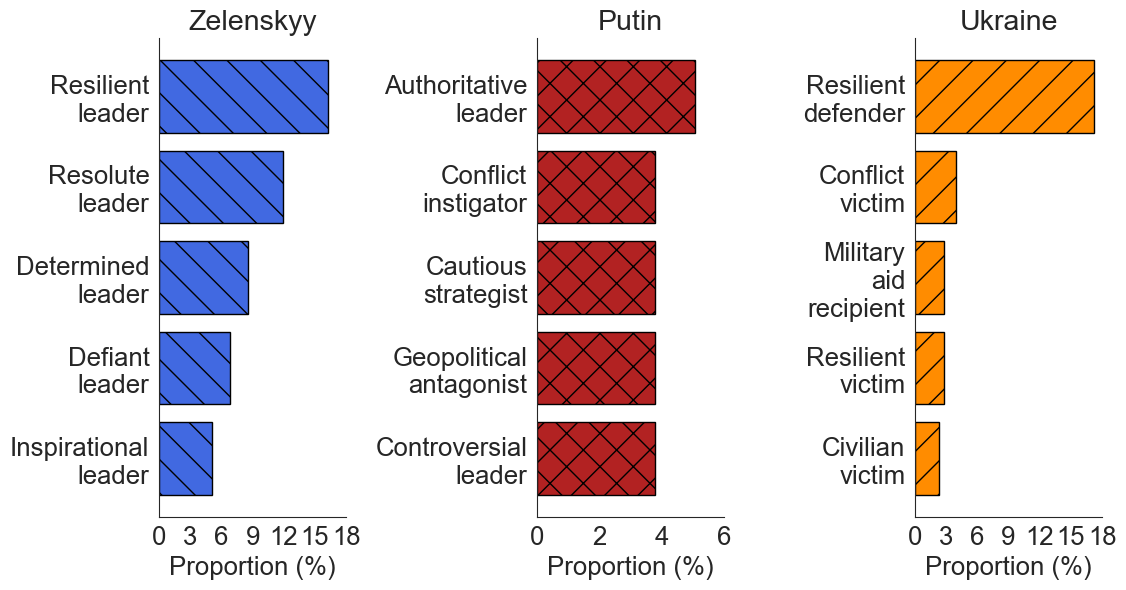

In [68]:
create_unified_chart(zelenskyy_top_labels, title='Zelenskyy', xlabel='Proportion (%)', position=1, total_positions=4, color='royalblue', hatch='\\')
create_unified_chart(putin_top_labels, title='Putin', xlabel='Proportion (%)', position=2, total_positions=4, color='firebrick', hatch='x')
create_unified_chart(ukraine_top_labels, title='Ukraine', xlabel='Proportion (%)', position=3, total_positions=4, color='darkorange', hatch="/")
plt.savefig(os.path.join(plot_savepath, "ukraine_char_plot.png"))
plt.show()

#### Role Entropy

In [9]:
# Compute top-k role entropy for given character for all label columns
def compute_character_role_entropies(df, char, k, label_cols):
    df_tmp = df.loc[df['character'] == char]
    entropies = dict()
    for label_col in label_cols:
        label_distribution = df_tmp[label_col].value_counts(normalize=True)
        top_k_label_distribution = label_distribution.iloc[:k]
        entropies[f'{label_col}_entropy'] = entropy(top_k_label_distribution)
    return entropies

# Compute top-k role entropy for all characters for all label columns
# Returns pd.DataFrame
def compute_role_entropies(df, char_list, k, label_cols):
    char_entropies = {char: compute_character_role_entropies(df, char, k, label_cols) for char in char_list}
    return pd.DataFrame(char_entropies).T

In [10]:
# Get top characters
n_chars = 5
top_chars = df.character.value_counts().head(n_chars).index

# Compute role entropies
k = 50    # first 50 labels per character
label_cols = ['clustered_base_label', 'clustered_full_label']
top_char_entropies = compute_role_entropies(df, top_chars, k, label_cols)

# top characters sorted by full label entropy
top_char_entropies = top_char_entropies.sort_values('clustered_full_label_entropy')
display(top_char_entropies)

,clustered_base_label_entropy,clustered_full_label_entropy
russia,1.642077,3.012461
ukraine,2.325678,3.190631
volodymyr zelensky,1.227095,3.246720
united state,2.317965,3.557797
vladimir putin,2.319228,3.800867


In [11]:
# For Ukraine, Zelenskyy, Putin
print((top_char_entropies
       .loc[['ukraine', 'volodymyr zelensky', 'vladimir putin']]
       .rename(index={'ukraine': 'Ukraine', 'volodymyr zelensky': "Zelenskyy", 'vladimir putin': "Putin"}, 
               columns={'clustered_base_label_entropy': "Prim.", 'clustered_full_label_entropy': 'Full'})
       .to_latex(float_format="%.2f")
    )
)

\begin{tabular}{lrr}
\toprule
 & Prim. & Full \\
\midrule
Ukraine & 2.33 & 3.19 \\
Zelenskyy & 1.23 & 3.25 \\
Putin & 2.32 & 3.80 \\
\bottomrule
\end{tabular}



### Appendix: Obama Plot

In [12]:
cate = 'immigration'
df = df_all.loc[df_all.cate == cate]
label_col = 'clustered_full_label'
top_n = 20

# Get top labels by HVV type
obama_top_labels = get_top_labels_for_character_by_hero_type(df, 'barack obama', label_col, top_n, give_hvv_percentage=False)

# Get top labels across all HVV types
obama_top_labels = obama_top_labels.sort_values(by='proportion', ascending=False).head(12).reset_index()

In [13]:
# Reformat data for plotting

# Fix a couple full label equivalence msitakes from the clustering
manual_full_label_equivalence = {
    'immigration reform proponent': 'immigration reform advocate',
    'reformist advocate': 'immigration reform advocate'
}
obama_top_labels[label_col] = obama_top_labels[label_col].apply(lambda x: manual_full_label_equivalence.get(x, x))
obama_top_labels = obama_top_labels.groupby(['hero_type', label_col]).sum().sort_values(by='proportion', ascending=False)

# Capitalize columns
obama_top_labels = obama_top_labels.reset_index()
obama_top_labels[label_col] = obama_top_labels[label_col].str.capitalize()
obama_top_labels['hero_type'] = obama_top_labels['hero_type'].str.capitalize()

# Reorder rows for plotting
obama_top_labels = obama_top_labels.iloc[::-1]

Plot

/var/folders/ck/5ckvvdj16djdr7jjfqxvb51m0000gn/T/ipykernel_78401/570037148.py:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


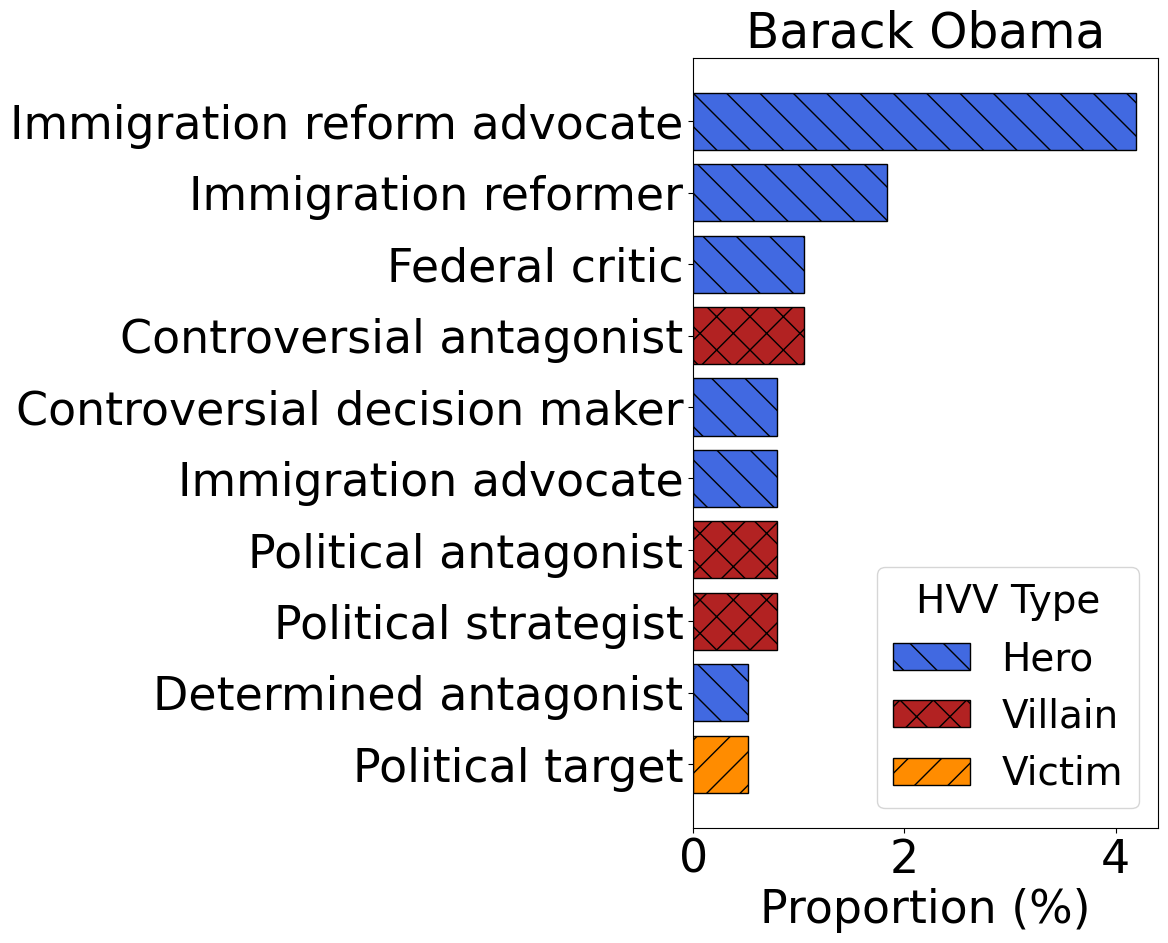

In [14]:
fig, ax = plt.subplots(figsize=(6, 10))

fontsize = 33

hero_styles = {
    'Hero': {'color': 'royalblue', 'hatch': '\\'},
    'Villain': {'color': 'firebrick', 'hatch': 'x'},
    'Victim': {'color': 'darkorange', 'hatch': '/'},
}

for i, row in obama_top_labels.iterrows():
    style = hero_styles[row["hero_type"]]
    ax.barh(
        row["clustered_full_label"],
        row["proportion"],
        color=style["color"],
        hatch=style["hatch"],
        edgecolor="black"
    )

ax.set_xlabel("Proportion (%)", fontsize=fontsize)
ax.set_title("Barack Obama", fontsize=fontsize+2)

ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)

# Custom legend
handles = [
    plt.Rectangle((0,0), 1, 1, facecolor=style["color"], hatch=style["hatch"], edgecolor="black")
    for style in hero_styles.values()
]
ax.legend(handles, hero_styles.keys(), title="HVV Type", fontsize=fontsize-5, title_fontsize=fontsize-5)

plt.savefig(os.path.join(plot_savepath, "obama_dist.png"), bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

## 2) Non-HVV Narratives

In [15]:
# Compute the HVV breakdowns of the labels in the given list and label column
def get_label_hvv_breakdowns(df, label_list, label_col, hvv_col='hero_type'):
    df = df.loc[df[label_col].isin(label_list)]
    hvv_breakdowns = (pd.crosstab(df[label_col], df[hvv_col], normalize='index')
        .loc[label_list]               # reorders labels to be the same order as the ones provided (instead of alphabetical)
        .rename_axis(None, axis=0)     # remove row axis name
        .rename_axis(None, axis=1)     # remove column axis name
        .round(4)*100
    )
    return hvv_breakdowns

In [33]:
# Create a horizontal stacked bar chart for the DataFrame with the given hero type distributions
def create_stacked_hero_chart(
        df, 
        title="Hero Type Distribution", 
        figsize=None, 
        ax=None, 
        show_legend=True, 
        legend_loc='upper left',
        hero_types=['neither', 'hero', 'villain', 'victim']
    ):
    plot_df = df.copy()
    
    fontsize=24

    # Custom color and hatch styles
    hero_styles = {
        'hero': {'color': 'royalblue', 'hatch': '\\'},
        'villain': {'color': 'firebrick', 'hatch': 'x'},
        'victim': {'color': 'darkorange', 'hatch': '/'},
        'neither': {'color': 'mediumseagreen', 'hatch': ''}
    }
    
    # Extract colors and hatches in the correct order for plotting
    colors = [hero_styles[hero_type]['color'] for hero_type in hero_types]
    hatches = [hero_styles[hero_type]['hatch'] for hero_type in hero_types]
    
    # Create the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the stacked horizontal bars
    bars = plot_df.plot(kind='barh', stacked=True, ax=ax, color=colors, legend=show_legend)
    
    # Apply hatches to the bars
    bar_container = bars.containers
    for i, container in enumerate(bar_container):
        for j, patch in enumerate(container):
            patch.set_hatch(hatches[i])
            patch.set_edgecolor('black')
            patch.set_linewidth(0.5)
    
    ax.set_title(title, fontsize=fontsize+4, pad=20)
    ax.set_xlabel('Label Breakdown (%)', fontsize=fontsize)
    ax.set_ylabel('', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.xaxis.set_ticks(np.arange(0, 101, 25))

    # # Remove gridlines
    # ax.grid(False)
    
    # Customize legend
    if show_legend:
        legend = ax.legend(title='HVV Type', loc=legend_loc, bbox_to_anchor=(1.05, 1), fontsize=fontsize, title_fontsize=fontsize)
        
        # Add hatches to legend
        for i, patch in enumerate(legend.get_patches()):
            patch.set_hatch(hatches[i])
            patch.set_edgecolor('black')
            patch.set_linewidth(0.5)
    
    return ax

# Create side-by-side horizontal stacked bar charts from two DataFrames
def create_side_by_side_charts(
        df1, 
        df2, 
        title1="Dataset 1", 
        title2="Dataset 2", 
        figsize=(12, 10),
        save_filename=None
    ):
    # Create the figure and axes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Create the first and second charts
    create_stacked_hero_chart(df1, title=title1, ax=ax1, show_legend=False)
    create_stacked_hero_chart(df2, title=title2, ax=ax2, show_legend=False)
    
    # Adjust layout
    plt.tight_layout()
    fig.patch.set_facecolor('white')     # Ensure background is white
    fig.patch.set_edgecolor('none')      # Remove figure border
    
    # Save if path is provided
    if save_filename:
        plt.savefig(save_filename, bbox_inches='tight', dpi=300)

    return fig

Compute HVV breakdowns

In [34]:
label_col = 'clustered_base_label'
n_labels = 6

# Tech
df_tech = df_all.loc[df_all.cate == 'tech_and_jobs']
top_tech_labels = df_tech[label_col].value_counts().head(n_labels).index
hvv_breakdown_tech = get_label_hvv_breakdowns(df_tech, top_tech_labels, label_col)

# Ukraine
df_ukr = df_all.loc[df_all.cate == 'ukraine']
top_ukr_labels = df_ukr[label_col].value_counts().head(n_labels).index
hvv_breakdown_ukr = get_label_hvv_breakdowns(df_ukr, top_ukr_labels, label_col)

Plot

In [35]:
# Reformat data for plotting
hvv_breakdown_tech = (hvv_breakdown_tech[['neither', 'hero', 'villain', 'victim']]
    .iloc[::-1]                                                                       
    .rename(
        index={idx:idx.capitalize() for idx in hvv_breakdown_tech.index},
        columns={col:col.capitalize() for col in hvv_breakdown_tech.columns}
    )
)            
hvv_breakdown_ukr = (hvv_breakdown_ukr[['neither', 'hero', 'villain', 'victim']]
    .iloc[::-1]
    .rename(
        index={idx:idx.capitalize() for idx in hvv_breakdown_ukr.index},
        columns={col:col.capitalize() for col in hvv_breakdown_ukr.columns}
    )
)
    

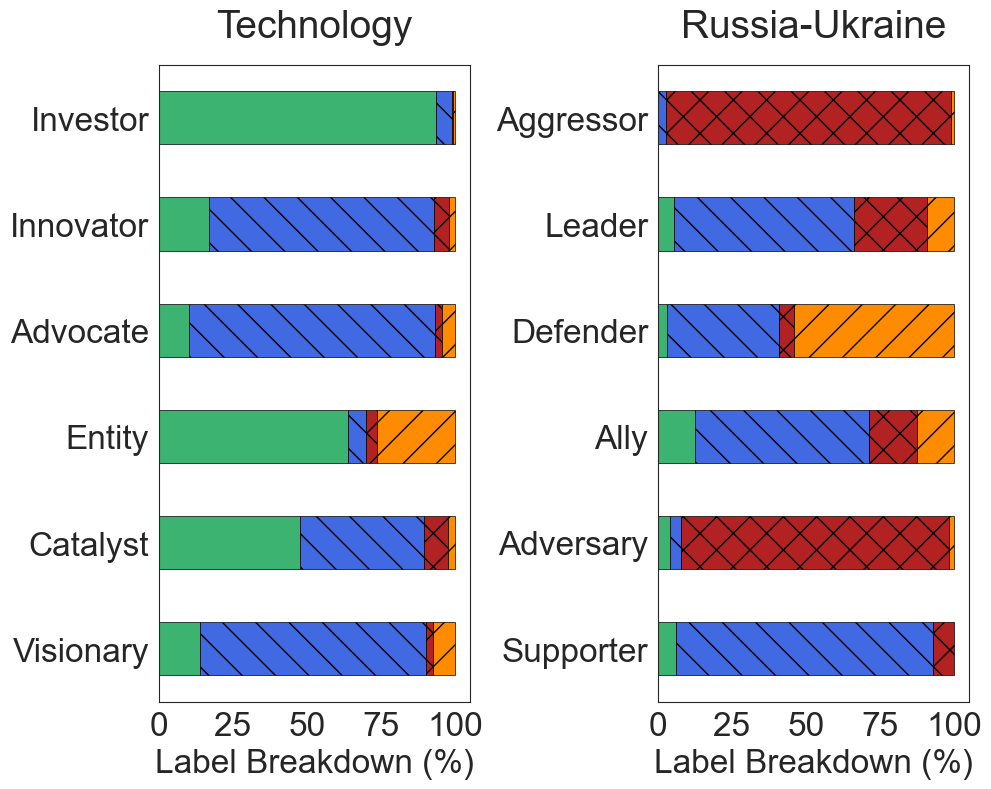

In [36]:
create_side_by_side_charts(
    hvv_breakdown_tech,
    hvv_breakdown_ukr, 
    title1="Technology", 
    title2="Russia-Ukraine",
    figsize=(10, 8),
    save_filename=os.path.join(plot_savepath, "beyond_hvv.png")
)
plt.show()

## 3) Cross-narrative role similarity

In [20]:
cates = ['ukraine', 'tech_and_jobs', 'samesex', 'immigration', 'climate']

label_col = 'clustered_base_label'

In [21]:
# Get percentage of articles that contain each label
def get_label_percentages_by_article(df, label_col, article_col='orig_index', proportion_threshold=0):
    label_article_indicator = pd.crosstab(df[article_col], df[label_col]) > 0
    label_proportion = label_article_indicator.mean().sort_values(ascending=False)
    
    # Filter by proportion threshold
    label_proportion = label_proportion.loc[label_proportion >= proportion_threshold]
    
    return label_proportion

In [22]:
# Get percentages of articles that contain each label
label_proportions_data = []
for cate in cates:
    label_percentages_cate = get_label_percentages_by_article(df_all.loc[df_all.cate == cate], label_col)
    label_proportions_data.append(label_percentages_cate.rename(f"{cate}"))
label_proportions = pd.concat(label_proportions_data, axis=1)

# Clean up data
label_proportions = (label_proportions
    .fillna(0)
    .rename(columns={col: col.capitalize() for col in cates})
    .rename_axis(None, axis=0)
)

label_proportions

,Ukraine,Tech_and_jobs,Samesex,Immigration,Climate
aggressor,0.350806,0.017279,0.00025,0.00225,0.00075
leader,0.320565,0.119330,0.04475,0.06075,0.10100
defender,0.308468,0.037257,0.09950,0.06450,0.04350
ally,0.280242,0.065335,0.09400,0.04825,0.04300
adversary,0.252016,0.043737,0.03650,0.03750,0.03975
...,...,...,...,...,...
cutter,0.000000,0.000000,0.00000,0.00000,0.00025
princeling,0.000000,0.000000,0.00000,0.00000,0.00025
princess,0.000000,0.000000,0.00000,0.00000,0.00025
principled dissenter,0.000000,0.000000,0.00000,0.00000,0.00025


In [23]:
# Get ranked labels by category with the corresponding percentages by category
top_n = 10
ranked_label_proportions_data = []
for cate in cates:
    top_n_label_proportions = (label_proportions[cate.capitalize()]
        .sort_values(ascending=False)
        .rename(f"proportion_{cate}")
        .rename_axis(cate, axis=0)
        .round(4)*100
    )
    ranked_label_proportions_data.append(top_n_label_proportions.reset_index())
ranked_labels_with_proportions = pd.concat(ranked_label_proportions_data, axis=1)

ranked_labels_with_proportions

,ukraine,proportion_ukraine,tech_and_jobs,proportion_tech_and_jobs,samesex,proportion_samesex,immigration,proportion_immigration,climate,proportion_climate
0,aggressor,35.08,innovator,26.57,advocate,59.70,advocate,40.15,advocate,44.75
1,leader,32.06,advocate,22.08,arbiter,22.60,enforcer,15.95,authority,14.55
2,defender,30.85,entity,15.60,supporter,19.30,authority,14.70,critic,12.10
3,ally,28.02,investor,14.25,opponent,16.10,critic,13.95,leader,10.10
4,adversary,25.20,visionary,13.44,defender,9.95,victim,12.72,skeptic,9.28
...,...,...,...,...,...,...,...,...,...,...
1180,nationalist,0.00,confessor,0.00,heir,0.00,fallen rival,0.00,apologist,0.00
1181,gentle soul,0.00,cleric,0.00,cultural ambassador,0.00,edgelord,0.00,conventional thinker,0.00
1182,neglecter,0.00,alleged criminal,0.00,influential observer,0.00,policy reverser,0.00,charity,0.00
1183,neutral party,0.00,agreeing voice,0.00,craftsman,0.00,device,0.00,embattled,0.00


In [24]:
ranked_labels = ranked_labels_with_proportions[[col for col in ranked_labels_with_proportions.columns if 'proportion' not in col]]
ranked_labels

,ukraine,tech_and_jobs,samesex,immigration,climate
0,aggressor,innovator,advocate,advocate,advocate
1,leader,advocate,arbiter,enforcer,authority
2,defender,entity,supporter,authority,critic
3,ally,investor,opponent,critic,leader
4,adversary,visionary,defender,victim,skeptic
...,...,...,...,...,...
1180,nationalist,confessor,heir,fallen rival,apologist
1181,gentle soul,cleric,cultural ambassador,edgelord,conventional thinker
1182,neglecter,alleged criminal,influential observer,policy reverser,charity
1183,neutral party,agreeing voice,craftsman,device,embattled


### RBO 

In [25]:
# Compute the extrapolated Rank-Biases Overlap (RBO EXT) between two ranked lists
def rbo_ext(S, T, p=0.9):
    if not 0 < p < 1:
        raise ValueError("p must be between 0 and 1 (exclusive)")

    S_len, T_len = len(S), len(T)
    depth = max(S_len, T_len)
    overlap = 0
    cumulative = 0.0

    seen_S = set()
    seen_T = set()

    for d in range(1, depth + 1):
        if d <= S_len:
            seen_S.add(S[d - 1])
        if d <= T_len:
            seen_T.add(T[d - 1])
        current_overlap = len(seen_S & seen_T)
        agreement = current_overlap / d
        cumulative += agreement * (p ** (d - 1))

    k = min(S_len, T_len)
    X_k = len(set(S[:k]) & set(T[:k]))
    
    rbo_ext = (1 - p) * cumulative + (p ** depth) * (X_k / k)
    return rbo_ext

# Compute pairwise RBO scores between dataframe columns
def get_rbo_matrix(df, p=0.9):
    cates = df.columns
    n_cates = len(cates)

    # Initialize empty dataframe
    rbo_matrix = pd.DataFrame(index=cates, columns=cates, dtype=float)
    
    for i in range(n_cates):
        for j in range(n_cates):
            rbo_matrix.iloc[i, j] = rbo_ext(df.iloc[:, i], df.iloc[:, j], p=p)

    return rbo_matrix

In [30]:
# Plot a trimmed upper-triangle similarity heatmap from a DataFrame.
# Removes the last row and first column from the heatmap to make it more compact.
def plot_upper_triangular_similarity_heatmap(matrix, title="Narrative Role Similarity", savepath=None):
    fontsize=18

    # Mask the lower triangle and diagonal
    mask = np.tril(np.ones_like(matrix.values, dtype=bool))

    # Remove last row and first column
    trimmed_matrix = matrix.iloc[:-1, 1:]
    trimmed_mask = mask[:-1, 1:]

    fig = plt.figure(figsize=(7, 5))
    sns.heatmap(trimmed_matrix, mask=trimmed_mask, annot=True, cmap=sns.cm.rocket_r, vmin=0, vmax=1, fmt=".2f", annot_kws={"size": fontsize})
    plt.title(title)
    plt.xticks(rotation=45, fontsize=fontsize)
    plt.yticks(rotation=0, fontsize=fontsize)
    plt.tight_layout()
    sns.set_style("white")
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

Compute RBO

In [31]:
# Reformat data for plotting
ranked_labels = (ranked_labels
    .rename(columns={
            'ukraine': 'Rus-Ukr',
            'tech_and_jobs': 'Technology',
            'climate': 'Climate',
            'immigration': 'Immigration',
            'samesex': 'SSM'
        })
    .loc[:,['Rus-Ukr', 'Technology', 'Immigration', 'Climate', 'SSM']]
)

# Compute RBO scores
rbo_matrix = get_rbo_matrix(ranked_labels, p=0.9)

Plot

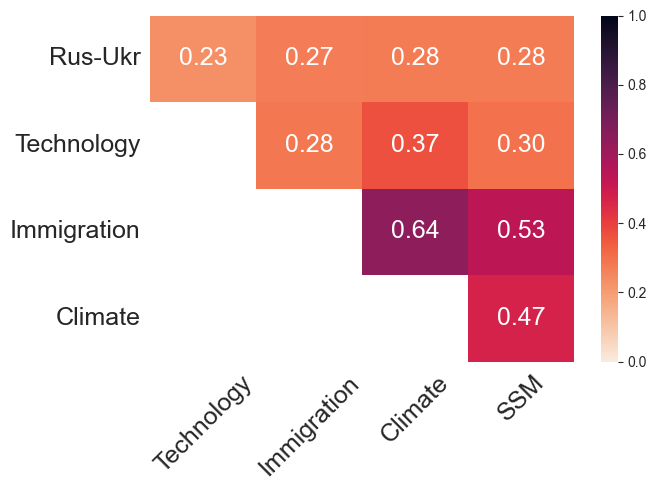

In [32]:
title=""
savepath = os.path.join(plot_savepath, 'cross_narrative_role_similarity.png')

# Example call with trimming
plot_upper_triangular_similarity_heatmap(rbo_matrix, title=title, savepath=savepath)

Sample top ranked labels

In [29]:
print((ranked_labels[['Climate', 'Immigration', 'Rus-Ukr']]
        .head(5)
        .map(lambda x: x.capitalize())
        .to_latex(index=False)
    )    
)

\begin{tabular}{lll}
\toprule
Climate & Immigration & Rus-Ukr \\
\midrule
Advocate & Advocate & Aggressor \\
Authority & Enforcer & Leader \\
Critic & Authority & Defender \\
Leader & Critic & Ally \\
Skeptic & Victim & Adversary \\
\bottomrule
\end{tabular}

